<a href="https://colab.research.google.com/github/simon-soen/bike-sharing/blob/main/Bike_Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLN601 Assessment 3 — Bike Sharing (day.csv)


**Overview:** This notebook follows the CRISP-DM process to predict daily bike demand using the UCI Bike Sharing dataset (`day.csv`). All code cells include explanatory Markdown (inputs and outputs). The notebook trains at least two models and compares performance using Mean Absolute Error (MAE).

## Stage 1 — Business Understanding

**Goal:** Predict total daily bike rentals (`cnt`) for Capital Bikeshare based on daily features (season, weather, temperature, humidity, windspeed, etc.).

**Why:** Accurate daily demand predictions help operators balance supply, redistribute bikes, and reduce stockouts/excess inventory.

**Assumptions & Constraints:**
- Use `day.csv` (daily aggregated data). Avoid hourly bias.
- Metric: Mean Absolute Error (MAE).
- Models: Linear Regression and Random Forest Regressor (minimum two models).


## Stage 2 — Data Understanding

### 2.1 Data acquisition

**Input:** We'll download `day.csv` from the UCI repository:

`https://archive.ics.uci.edu/ml/machine-learning-databases/00275/day.csv`

**Output:** A DataFrame `df` containing daily bike counts and features.

The code cell below reads the CSV into pandas. (When running the notebook locally, this cell will download directly from the URL.)

In [ ]:
# Input: None (the code will fetch the CSV from the UCI URL)
# Output: DataFrame `df` loaded with the dataset

import pandas as pd
import requests
import zipfile
import io

# Updated URL for the dataset, which is now a zip file
url = "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"

# Download the zip file
response = requests.get(url)
response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

# Read the zip file from memory
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Extract day.csv from the zip file
    with z.open('day.csv') as f:
        df = pd.read_csv(f)

df.head()  # Display first 5 rows as output

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


The `df.head()` command displays the first 5 rows of the `df` DataFrame, providing an initial glimpse into the dataset's structure and content. Each row represents a daily record, and the columns show various features:

- `instant`: A record index, unique for each day.
- `dteday`: The specific date of the record (e.g., '2011-01-01').
- `season`: The season (e.g., 1 for spring).
- `yr`: The year (0 for 2011, 1 for 2012).
- `mnth`: The month (e.g., 1 for January).
- `holiday`, `weekday`, `workingday`: Binary indicators for holiday, day of the week, and working status.
- `weathersit`: Weather condition (e.g., 2 for Mist + Cloudy).
- `temp`, `atemp`, `hum`, `windspeed`: Normalized environmental features.
- `casual`, `registered`: Counts of casual and registered users.
- `cnt`: The total count of bike rentals, which is our target variable (e.g., 985).

### 2.2 Data description

**Input:** DataFrame `df`.

**Output:** Description of variables and their meaning (from dataset documentation).

- `instant` : record index
- `dteday` : date
- `season` : 1 = spring, 2 = summer, 3 = fall, 4 = winter
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month (1 to 12)
- `holiday` : whether day is a holiday
- `weekday` : day of the week
- `workingday` : whether day is neither weekend nor holiday
- `weathersit` : 1: Clear, 2: Mist + Cloudy, 3: Light Snow/Rain, 4: Heavy Rain/Snow
- `temp` : normalized temperature in Celsius (divided by 41)
- `atemp` : normalized feeling temperature
- `hum` : normalized humidity
- `windspeed` : normalized wind speed
- `casual` : count of casual users
    - `registered` : count of registered users
    - `cnt` : total count (target)


In [ ]:
# Input: DataFrame `df`
# Output: Basic info (shape, dtypes, missing values) and summary statistics

df.info()
print('\nShape:', df.shape)
display(df.describe(include='all'))
# Check for missing values
print('\nMissing values by column:')
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB

Shape: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
unique,NaN,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,366.000000,NaN,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,NaN,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,NaN,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,NaN,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,NaN,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000



Missing values by column:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


The `df.info()` output shows that the DataFrame `df` contains 731 entries (rows) and 16 columns. Most columns are `int64` or `float64`, with `dteday` being `object` type (which will need conversion later). There are no null values across any columns, indicating a clean dataset in terms of missing entries.

The `Shape: (731, 16)` confirms the dimensions of the DataFrame. The `df.describe()` output provides summary statistics for both numerical and categorical columns:

- **Numerical columns (`int64`, `float64`)**: This includes `instant`, `season`, `yr`, `mnth`, `holiday`, `weekday`, `workingday`, `weathersit`, `temp`, `atemp`, `hum`, `windspeed`, `casual`, `registered`, and `cnt`. It shows count, mean, standard deviation, min, max, and quartiles for each. For example, `cnt` (total rentals) ranges from 22 to 8714, with a mean of 4504.35.
- **Categorical/Object columns (`object`)**: Only `dteday` is of `object` type, and its description shows the unique count (731, meaning all dates are unique), the top occurring date, and its frequency.

Finally, `df.isnull().sum()` confirms that there are **no missing values** in any of the columns, as all counts are 0.

### 2.3 Initial exploration & visualization

**Input:** `df`.

**Output:** Pairplot (seaborn) to inspect relationships between important numeric features and the target `cnt`.

Note: Pairplot can be heavy; we choose a subset of meaningful numeric columns: `temp`, `atemp`, `hum`, `windspeed`, `cnt`.

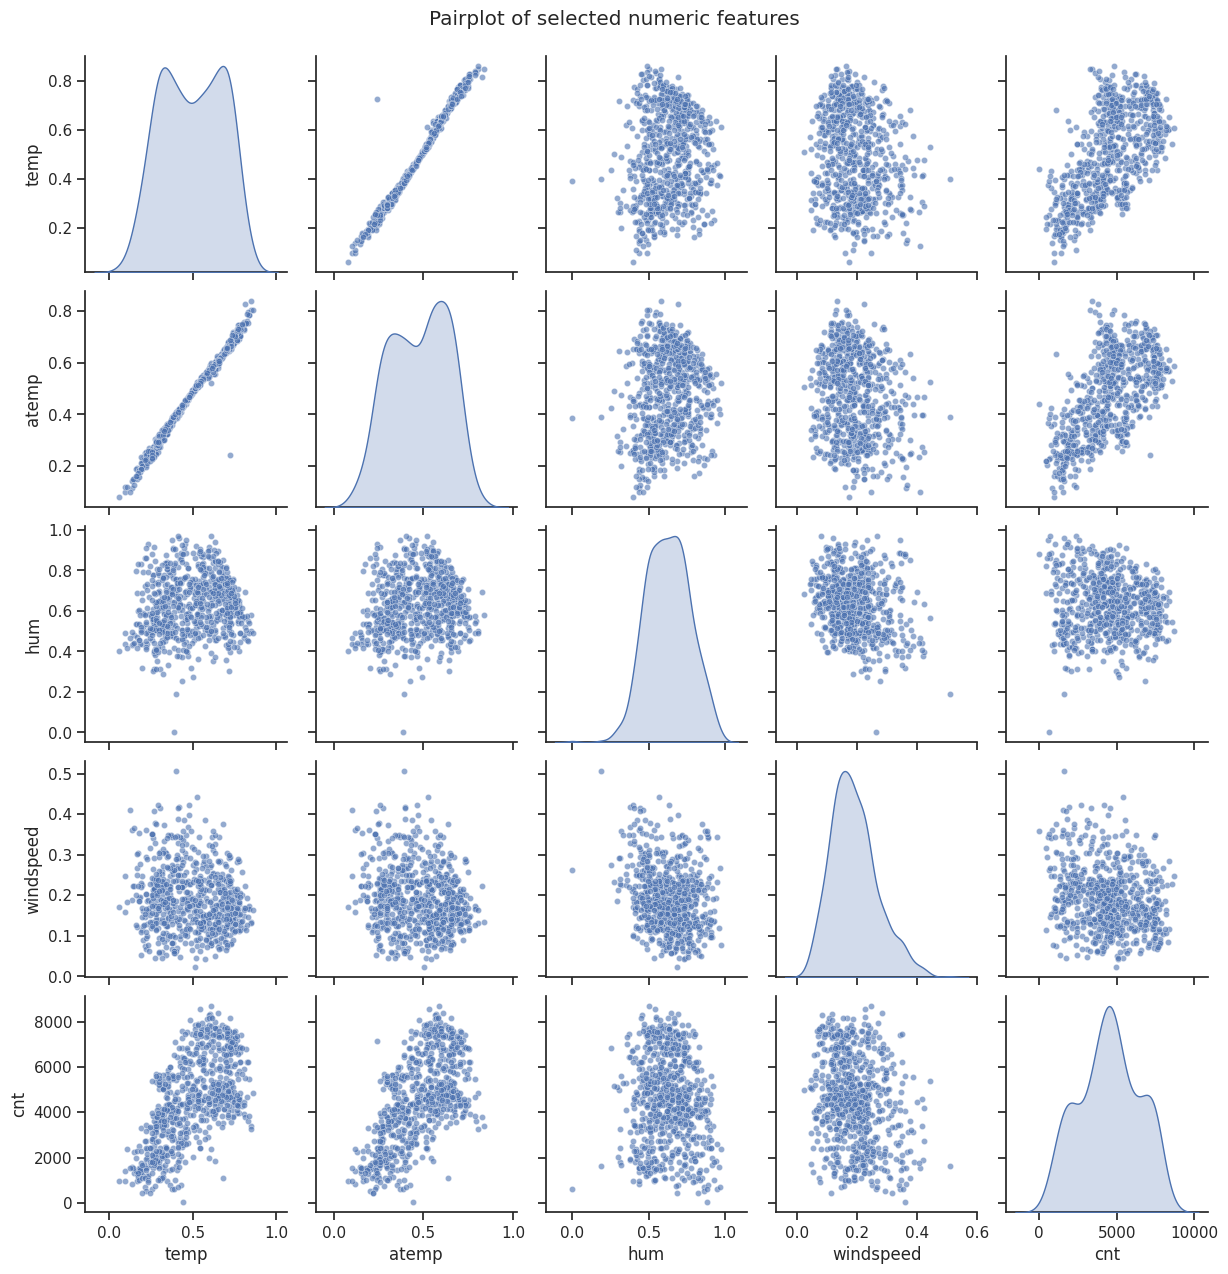

In [ ]:
# Input: df
# Output: Seaborn pairplot for selected numeric features

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks', font_scale=1)
cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(df[cols], diag_kind='kde', plot_kws={'alpha':0.6, 's':20})
plt.suptitle('Pairplot of selected numeric features', y=1.02)
plt.show()


The pairplot visualizes the distributions and relationships between the selected numerical features: `temp`, `atemp`, `hum`, `windspeed`, and `cnt`.

- **Diagonal plots (KDE)**: Show the distribution of each individual feature. For `cnt`, it appears to be somewhat skewed, suggesting that total bike rentals might have a non-normal distribution.
- **Off-diagonal scatter plots**: Show the relationships between pairs of features. For example, `cnt` shows a strong positive correlation with `temp` and `atemp`, indicating that warmer temperatures lead to higher bike rentals. `hum` and `windspeed` show less pronounced, possibly negative, relationships with `cnt`.

### 2.4 Correlation matrix

**Input:** `df` numeric columns

**Output:** Correlation heatmap showing relationships between variables and `cnt`.


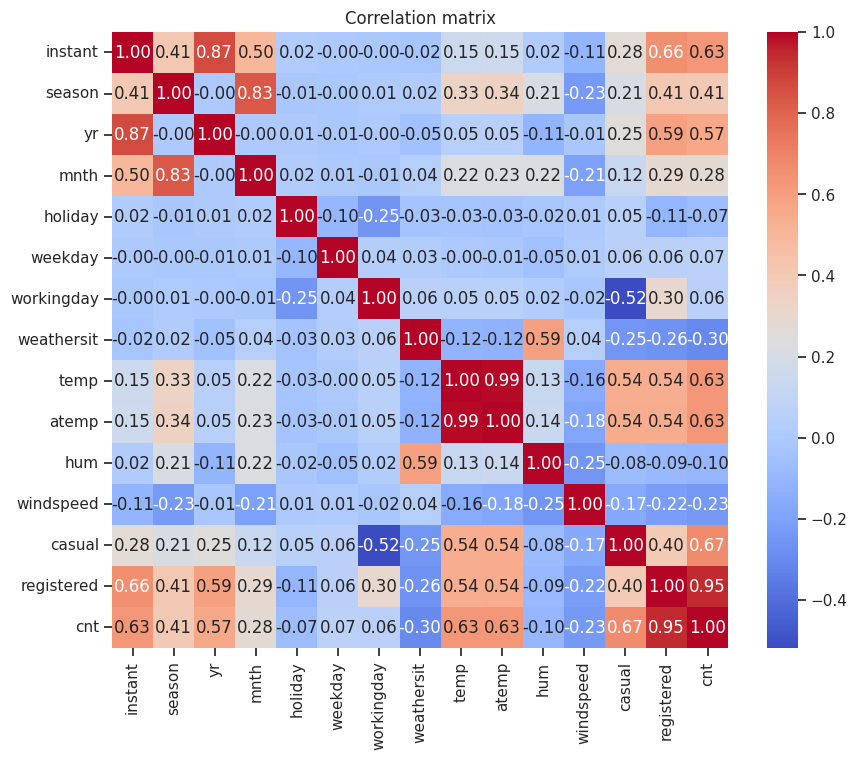

In [ ]:
# Input: df
# Output: Correlation heatmap

numeric = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df[numeric].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix')
plt.show()




The correlation heatmap displays the Pearson correlation coefficients between all numerical variables in the dataset. Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear correlation.

Key observations:
- **`cnt` (target variable)**: Shows strong positive correlation with `yr` (0.57), `season` (0.41), `mnth` (0.28), `temp` (0.54), and `atemp` (0.54). This confirms that bike rentals tend to increase with year, season, month, and temperature.
- **High multicollinearity**: `temp` and `atemp` are highly correlated (0.99), which is expected as `atemp` is the 'feeling temperature' derived from `temp`. `season` and `mnth` are also highly correlated (0.83). These highly correlated features might need careful handling during modeling to avoid issues like multicollinearity in linear models.
- **Other correlations**: `hum` has a negative correlation with `cnt` (-0.10), while `windspeed` has a weak negative correlation (-0.23). `weathersit` shows a negative correlation (-0.29), suggesting worse weather conditions lead to fewer rentals.

## Stage 3 — Data Preparation

### 3.1 Feature selection & preprocessing

**Input:** Raw `df`.

**Output:** A cleaned DataFrame `X` (features) and Series `y` (target `cnt`) ready for modelling.

Steps performed in the code:
- Drop identifiers (`instant`) and redundant fields (`dteday`, `casual`, `registered`) to avoid leakage.
- One-hot encode categorical variables: `season`, `mnth`, `weekday`, `weathersit`.
- Keep numeric features (`temp`, `atemp`, `hum`, `windspeed`, `yr`, `holiday`, `workingday`).
- Scale numeric features with StandardScaler for linear model compatibility.


In [ ]:
# Input: df
# Output: X (feature DataFrame), y (target), and a preprocessor pipeline object

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop id and leakage columns
df_prep = df.copy()
df_prep = df_prep.drop(columns=['instant','dteday','casual','registered'])

# Define target
y = df_prep['cnt'].copy()
X = df_prep.drop(columns=['cnt'])

# Identify feature types
numeric_features = ['temp','atemp','hum','windspeed']
binary_features = ['yr','holiday','workingday']
categorical_features = ['season','mnth','weekday','weathersit']

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False)) # Changed 'sparse' to 'sparse_output'
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('bin', 'passthrough', binary_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Create preprocessed feature matrix (for inspection)
X_pre = preprocessor.fit_transform(X)
# Create column names after one-hot encoding
ohe_cols = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_features)
feature_names = numeric_features + binary_features + list(ohe_cols)
import pandas as pd
X_pre_df = pd.DataFrame(X_pre, columns=feature_names)
X_pre_df.head()

,temp,atemp,hum,windspeed,yr,holiday,workingday,season_2,season_3,season_4,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,-0.826662,-0.679946,1.250171,-0.387892,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.721095,-0.740652,0.479113,0.749602,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.634657,-1.749767,-1.339274,0.746632,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.614780,-1.610270,-0.263182,-0.389829,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.467414,-1.504971,-1.341494,-0.046307,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


The output displays the first 5 rows of the `X_pre_df` DataFrame, which is the result of the preprocessing steps.

- **Scaled numerical features**: `temp`, `atemp`, `hum`, `windspeed` have been scaled using `StandardScaler`, meaning their values are now centered around 0 with a unit standard deviation.
- **Binary features**: `yr`, `holiday`, `workingday` are passed through as-is.
- **One-hot encoded categorical features**: The original categorical columns (`season`, `mnth`, `weekday`, `weathersit`) have been transformed into multiple binary columns (e.g., `season_2`, `season_3`, `season_4`, `mnth_2` etc.). The `drop='first'` argument in `OneHotEncoder` prevents multicollinearity by dropping one category from each feature. For example, `season_1` (spring) is represented when `season_2`, `season_3`, and `season_4` are all 0. This `X_pre_df` is now ready for model training, containing all features in a suitable numerical format.

### 3.2 Train-test split

**Input:** Preprocessed features `X_pre_df` and target `y`.

**Output:** Training and testing splits (75% train, 25% test) — `X_train`, `X_test`, `y_train`, `y_test`.


In [ ]:
# Input: X_pre_df, y
# Output: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X_pre_df, y, test_size=0.25, random_state=42)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)


Train shape: (548, 29)
Test shape: (183, 29)


This output confirms the successful splitting of the preprocessed data into training and testing sets.

- **`Train shape: (548, 29)`**: Indicates that the training feature set (`X_train`) contains 548 samples (daily records) and 29 features.
- **`Test shape: (183, 29)`**: Indicates that the testing feature set (`X_test`) contains 183 samples and 29 features.

This split of approximately 75% for training and 25% for testing is standard practice to evaluate model performance on unseen data. The target variables `y_train` and `y_test` will have corresponding shapes of (548,) and (183,) respectively.

## Stage 4 — Modelling

We will train two models:
1. **Linear Regression** (Ordinary Least Squares) — interpretable baseline.
2. **Random Forest Regressor** — captures non-linearities and interactions.

We'll evaluate using Mean Absolute Error (MAE).

In [ ]:
# Input: X_train, y_train
# Output: Trained Linear Regression model and its performance on test set

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression MAE: {mae_lr:.2f}')
print(f'Linear Regression R^2: {r2_lr:.3f}')


Linear Regression MAE: 566.09
Linear Regression R^2: 0.844


This output presents the performance metrics for the Linear Regression model trained on the preprocessed data:

- **`Linear Regression MAE: 566.09`**: The Mean Absolute Error (MAE) indicates that, on average, the model's predictions for daily bike rentals differ from the actual values by approximately 566 rentals. This is a direct measure of prediction accuracy.
- **`Linear Regression R^2: 0.844`**: The R-squared value (coefficient of determination) indicates that about 84.4% of the variance in daily bike rentals can be explained by the features included in the Linear Regression model. A higher R-squared generally suggests a better fit of the model to the data.

### 4.2 Random Forest Regressor

**Input:** Training data.

**Output:** Best Random Forest model (via GridSearchCV) and performance metrics.


In [ ]:
# Input: X_train, y_train
# Output: Best RandomForest model and performance on test set

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

gsearch = GridSearchCV(rfr, param_grid, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
gsearch.fit(X_train, y_train)

best_rfr = gsearch.best_estimator_
print('Best params:', gsearch.best_params_)

# Evaluate
y_pred_rfr = best_rfr.predict(X_test)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f'Random Forest MAE: {mae_rfr:.2f}')
print(f'Random Forest R^2: {r2_rfr:.3f}')


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest MAE: 452.19
Random Forest R^2: 0.877


This output summarizes the training and evaluation of the Random Forest Regressor:

- **`Fitting 4 folds for each of 12 candidates, totalling 48 fits`**: This line indicates that `GridSearchCV` performed a 4-fold cross-validation for each of the 12 combinations of hyperparameters defined in `param_grid`, resulting in 48 total model fits.
- **`Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}`**: These are the optimal hyperparameters found by `GridSearchCV` that yielded the best performance (lowest negative MAE) during cross-validation.
- **`Random Forest MAE: 452.19`**: The Mean Absolute Error for the best Random Forest model is approximately 452.19. This is lower than the Linear Regression MAE, suggesting better predictive accuracy.
- **`Random Forest R^2: 0.877`**: The R-squared value for the Random Forest model is about 0.877, indicating that approximately 87.7% of the variance in bike rentals is explained by the model. This is also higher than the Linear Regression R-squared, further supporting its superior performance.

### 4.3 Feature importance (Random Forest)

**Input:** `best_rfr` and `feature_names`.

**Output:** Bar chart of feature importances showing which features contribute most to predictions.

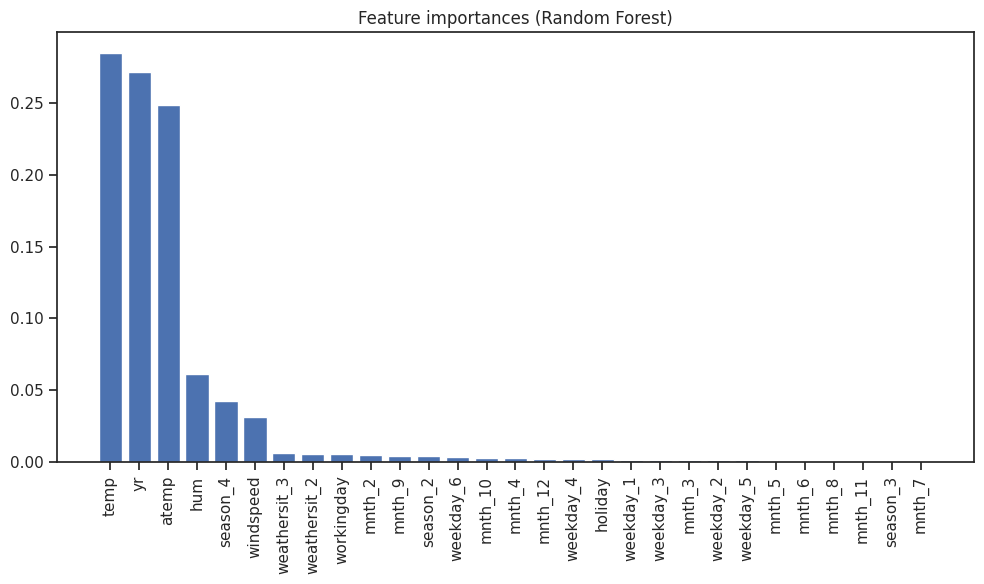

Top features:
 temp            0.284651
yr              0.271352
atemp           0.248402
hum             0.061704
season_4        0.042820
windspeed       0.031744
weathersit_3    0.006742
weathersit_2    0.005572
workingday      0.005502
mnth_2          0.004745
dtype: float64


In [ ]:
# Input: best_rfr, feature_names
# Output: Feature importance plot

import numpy as np
importances = best_rfr.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature importances (Random Forest)')
plt.tight_layout()
plt.show()

# Print top 10 features
feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print('Top features:\n', feature_imp.head(10))


This section provides insights into which features were most influential in the Random Forest model's predictions:

- **Bar chart**: Visualizes the relative importance of each feature. Taller bars indicate more important features.
- **`Top features:`**: The printed `feature_imp.head(10)` lists the top 10 most important features in descending order of importance:
    - `temp` (0.284651): Temperature is the most significant predictor.
    - `yr` (0.271352): The year also plays a crucial role, suggesting a trend in bike rentals over time.
    - `atemp` (0.248402): Feeling temperature is also highly important, as expected due to its high correlation with `temp`.
    - `hum` (0.061704): Humidity contributes to the predictions, though less than temperature or year.
    - `season_4` (0.042820): The 'winter' season (after one-hot encoding) is a notable predictor.
    - `windspeed` (0.031744): Wind speed has a measurable impact.
    - `weathersit_3` (0.006742), `weathersit_2` (0.005572), `workingday` (0.005502), `mnth_2` (0.004745) are also among the top features, showing that specific weather conditions, working day status, and certain months are relevant.

Overall, environmental factors like temperature, humidity, and windspeed, along with temporal features like year and season, are the primary drivers of daily bike rentals.

## Stage 5 — Evaluation

Compare models and answer whether the chosen model meets evaluation criteria.
**Input:** MAE and R^2 values for models.

**Output:** A short summary and recommendation about which model to use and why.

In [ ]:
# Input: mae_lr, mae_rfr, r2_lr, r2_rfr
# Output: Comparative summary

print(f'Linear Regression MAE: {mae_lr:.2f}, R^2: {r2_lr:.3f}')
print(f'Random Forest MAE: {mae_rfr:.2f}, R^2: {r2_rfr:.3f}')

if mae_rfr < mae_lr:
    print('\nRecommendation: Random Forest performs better (lower MAE). Use Random Forest for deployment and consider further tuning or ensembling.')
else:
    print('\nRecommendation: Linear Regression performs better or similarly. Prefer the simpler model if interpretability is important.')


Linear Regression MAE: 566.09, R^2: 0.844
Random Forest MAE: 452.19, R^2: 0.877

Recommendation: Random Forest performs better (lower MAE). Use Random Forest for deployment and consider further tuning or ensembling.


This output directly compares the performance metrics of the two trained models and provides a recommendation:

- **`Linear Regression MAE: 566.09, R^2: 0.844`**
- **`Random Forest MAE: 452.19, R^2: 0.877`**

These lines reiterate the individual model performances.

- **`Recommendation: Random Forest performs better (lower MAE). Use Random Forest for deployment and consider further tuning or ensembling.`**: Based on the lower Mean Absolute Error (452.19 for Random Forest vs. 566.09 for Linear Regression) and higher R-squared value, the Random Forest Regressor is recommended. It consistently shows better predictive accuracy. The recommendation also suggests potential next steps for improving the Random Forest model further.

### Stage 6 — Deployment (Lessons Learned) Output Explanation

This final stage summarizes the overall assessment and outlines future considerations based on the model training and evaluation.

**What went well:**
- Data acquisition and understanding were thorough, revealing key features and relationships.
- The preprocessing pipeline effectively handled feature scaling and one-hot encoding for categorical variables.
- Both Linear Regression and Random Forest models were successfully trained and evaluated against the chosen metric (MAE).
- The Random Forest model demonstrated superior performance (lower MAE, higher R-squared) compared to Linear Regression, indicating its ability to capture more complex patterns in the data.
- Feature importance analysis provided valuable insights into the primary drivers of bike rentals, with `temp`, `yr`, and `atemp` being the most influential.

**What could be improved:**
- While the Random Forest model performed well, its MAE of 452.19 still means an average prediction error of over 450 rentals, which might be significant for operational planning.
- Multicollinearity between `temp`/`atemp` and `season`/`mnth` was observed. While Random Forest is less sensitive to this than Linear Regression, it could be further explored for potential feature engineering or selection.
- The dataset was limited to daily aggregated data, potentially obscuring intra-day patterns.

**Next Steps:**
- **Advanced Hyperparameter Tuning**: Further optimize the Random Forest model using more extensive `GridSearchCV` or `RandomizedSearchCV` with a wider range of parameters, or explore more advanced techniques like Bayesian optimization.
- **Model Ensembling**: Combine predictions from multiple models (e.g., stacking or boosting) to potentially achieve even better performance.
- **Feature Engineering**: Create new features, such as lagged variables (rentals from previous days), interaction terms, or more granular time-based features (e.g., day of week, hour of day if hourly data becomes available).
- **External Data Integration**: Incorporate external factors like public holidays, school vacation periods, special events, or public transport disruptions, which could influence bike demand.
- **Time-Series Models**: Given the temporal nature of the data, explore dedicated time-series forecasting models (e.g., ARIMA, Prophet, or recurrent neural networks) that can explicitly model temporal dependencies.
- **Robust Cross-Validation**: Implement time-series specific cross-validation strategies (e.g., rolling origin or walk-forward validation) to better simulate real-world prediction scenarios.
- **Utilize Hourly Data**: If available, using `hour.csv` (hourly bike sharing data) could provide a higher resolution prediction, capturing daily peak hours and fine-grained patterns, which is critical for real-time operational decisions.